<a href="https://colab.research.google.com/github/hlliew/cvxpy-1/blob/master/portfolioAnalysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 7.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

#worksheet = gc.open('Portfolio Planning').'Covariance'
wb = gc.open_by_key('14b5X_DzcLsw46oOWYgD4zEWX8lHcLLak2wGFSClNP9s')

ws = wb.worksheet('Covariance')

# get_all_values gives a list of rows.
rows = ws.get_all_values()
print(rows) 


[['^GSPC', 'XLE', 'XLI', 'XLC', 'XLU', 'XLP', 'XLY', 'XLV', 'XLK', 'XLB', 'XLRE', 'XLF', '', '', '', '', '', '', '', ''], ['^GSPC', 'SPY', 'QQQ', 'VT', 'VTI', 'VOO', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['^GSPC', 'GOOG', 'BRK-B', 'NVDA', 'AAPL', 'MSFT', 'TSM', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['^GSPC', 'XLK', 'F', 'XLY', 'ACN', 'EXAS', 'XLK', 'ITW', 'TXN', 'EDIT', 'XLK', 'XLK', 'IBM', 'MRNA', 'CRSP', 'ILMN', 'ATA.TO', 'CGNX', 'AMAT', 'TWOU'], ['^GSPC', 'XLK', 'XLF', 'XLF', 'SQ', 'GTLB', 'CRSP', 'EDIT', '', '', '', '', '', '', '', '', '', '', '', ''], ['^GSPC', 'FSLR', 'OXY', 'XLB', 'LAC', 'LNG', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['^GSPC', 'TSM', 'ASML', 'BRK-B', 'HD', 'JPM', 'APPL', 'WFC', 'V', 'TRTN', 'WM', '', '', '', '', '', '', '', '', ''], ['^GSPC', 'EQIX', 'VNQ', 'IYR', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['^GSPC', 'TLT', 'IEF', 'SHY', 'TIP', 'BND', '', '', '', '', '', '', '', '', '', '',

In [4]:
type(rows)

list

In [5]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy import optimize
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('ggplot')

In [6]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,5


In [7]:
df = web.DataReader('GOOG', 'yahoo', start='2019-09-10', end='2019-10-09')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-10,1210.000000,1194.579956,1195.150024,1206.000000,1260100,1206.000000
2019-09-11,1222.599976,1202.199951,1203.410034,1220.170044,1307000,1220.170044
2019-09-12,1241.859985,1223.020020,1224.300049,1234.250000,1725900,1234.250000
2019-09-13,1240.880005,1227.010010,1231.349976,1239.560059,1301400,1239.560059
2019-09-16,1239.560059,1225.609985,1229.520020,1231.300049,1053300,1231.300049


In [8]:
# Portfolio
symbols = ['^GSPC', 
           'GOOG','BRK-B', 'NVDA', 'AAPL', 'MSFT', 'TSM',
           'XLK', 'F', 'XLY', 'ACN', 'EXAS', 'ITW', 'TXN', 'EDIT', 'IBM', 'CRSP', 'ILMN', 'CGNX', 'AMAT','ATA.TO',
           'XLF',
           'FSLR', 'OXY', 'XLB', 'LAC', 'LNG',
           'ASML', 'HD', 'JPM', 'WFC', 'V', 'TRTN', 'WM',
           'EQIX',
           'BAYN.DE', 'DD'
]


# Instantiate data frame container
close = pd.DataFrame()
# For loop to get data from Yahoo finance
for sym in symbols:
  # Each run of the loop returns a pandas data frame
  close[sym] = web.DataReader(
    name = sym, 
    data_source = 'yahoo',
    start = '2017-01-01',
    end = '2022-03-17'
    # Use [ to extract values as pandas series
    )['Adj Close']
# Set column indices
close.columns = symbols
# Examine the first 5 rows
close.head()

,^GSPC,GOOG,BRK-B,NVDA,AAPL,MSFT,TSM,XLK,F,XLY,...,ASML,HD,JPM,WFC,V,TRTN,WM,EQIX,BAYN.DE,DD
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2257.830078,786.140015,163.830002,25.166451,27.297689,58.065464,24.947176,45.738651,10.410684,77.295746,...,105.209862,118.883179,75.651794,48.028690,76.844200,12.910255,63.992710,329.587769,80.697723,68.585892
2017-01-04,2270.750000,786.900024,164.080002,25.753603,27.267138,57.805653,24.938663,45.898022,10.890285,78.324730,...,104.705009,119.936554,75.791344,48.071571,77.472511,13.423045,63.811237,336.193817,81.738983,69.133621
2017-01-05,2269.000000,794.020020,163.300003,25.099838,27.405804,57.805653,25.364241,45.973015,10.559525,78.268074,...,105.962379,118.520302,75.093689,47.325420,78.381081,13.513535,64.056236,339.721893,82.219559,68.824036
2017-01-06,2276.979980,806.150024,163.410004,25.435354,27.711329,58.306698,25.219542,46.310505,10.551255,78.655144,...,105.848076,118.192818,75.102402,47.205334,79.463676,13.822719,63.693272,340.401794,82.019325,68.395378
2017-01-09,2268.899902,806.650024,162.020004,26.466589,27.965153,58.121128,25.568514,46.301128,10.443758,78.589066,...,107.153084,118.883179,75.154724,46.519222,79.019043,13.837803,63.321205,342.882507,81.458641,68.812111


In [9]:

close.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2022-03-04', '2022-03-07', '2022-03-08', '2022-03-09',
               '2022-03-10', '2022-03-11', '2022-03-14', '2022-03-15',
               '2022-03-16', '2022-03-17'],
              dtype='datetime64[ns]', name='Date', length=1311, freq=None)

In [10]:
close.index = pd.to_datetime(close.index)

In [11]:
close.info()  # check for correct datatypes and non-nulls

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1311 entries, 2017-01-03 to 2022-03-17
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ^GSPC    1311 non-null   float64
 1   GOOG     1311 non-null   float64
 2   BRK-B    1311 non-null   float64
 3   NVDA     1311 non-null   float64
 4   AAPL     1311 non-null   float64
 5   MSFT     1311 non-null   float64
 6   TSM      1311 non-null   float64
 7   XLK      1311 non-null   float64
 8   F        1311 non-null   float64
 9   XLY      1311 non-null   float64
 10  ACN      1311 non-null   float64
 11  EXAS     1311 non-null   float64
 12  ITW      1311 non-null   float64
 13  TXN      1311 non-null   float64
 14  EDIT     1311 non-null   float64
 15  IBM      1311 non-null   float64
 16  CRSP     1311 non-null   float64
 17  ILMN     1311 non-null   float64
 18  CGNX     1311 non-null   float64
 19  AMAT     1311 non-null   float64
 20  ATA.TO   1284 non-null   float64
 

In [12]:
close.describe()

,^GSPC,GOOG,BRK-B,NVDA,AAPL,MSFT,TSM,XLK,F,XLY,...,ASML,HD,JPM,WFC,V,TRTN,WM,EQIX,BAYN.DE,DD
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,...,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1287.000000,1311.000000
mean,3173.652279,1493.717929,217.075576,92.814738,77.174416,157.151614,60.983306,91.913173,10.179589,125.127930,...,330.928676,218.953170,109.831180,43.431048,162.569411,34.598391,102.672711,551.218545,65.446153,72.177375
std,701.071080,633.081756,40.096222,71.712934,44.270734,80.689912,34.620707,36.505345,3.400601,35.355542,...,218.172150,72.029580,26.840542,8.922200,46.765509,12.323952,27.706735,163.298552,16.898212,12.986068
min,2237.399902,786.140015,158.809998,23.587652,27.267138,57.805653,24.930151,45.738651,3.969501,77.295746,...,104.705009,118.192818,72.051949,20.667673,76.844200,12.910255,62.776756,324.682831,38.872898,27.443390
25%,2668.424927,1064.974976,190.764999,42.339514,41.542477,90.614422,34.683388,63.329784,8.444615,99.631039,...,174.579124,164.979355,92.361446,42.291655,121.784367,26.662959,78.609558,407.573746,51.745449,65.274223
50%,2907.949951,1207.680054,206.779999,60.640377,53.649059,133.338699,40.687160,77.067772,9.372986,114.415237,...,213.629105,195.509705,100.876152,46.024849,169.354309,29.662151,101.697716,512.691956,59.538139,74.444763
75%,3632.529907,1747.340027,228.464996,131.842636,120.181084,213.871338,96.026897,122.441597,10.659504,154.944176,...,430.074371,267.287628,128.510590,48.884567,203.527122,42.636871,114.795582,705.393829,82.693531,80.627880
max,4796.560059,3014.179932,344.970001,333.662292,181.778397,342.402008,139.985336,176.324188,25.061152,210.780029,...,887.023926,413.683502,170.756454,59.060001,249.741714,68.470001,166.899994,882.830017,103.689423,97.055695


In [13]:
close[close.isna().any(axis=1)].head()  # show rows with na

,^GSPC,GOOG,BRK-B,NVDA,AAPL,MSFT,TSM,XLK,F,XLY,...,ASML,HD,JPM,WFC,V,TRTN,WM,EQIX,BAYN.DE,DD
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-17,2349.010010,837.169983,164.350006,24.511503,33.477551,61.124584,27.262299,49.735558,9.364572,82.791397,...,123.994255,131.183578,75.305878,45.522671,86.975029,20.461145,66.176308,372.275177,NaN,74.616638
2017-05-01,2388.330078,912.570007,165.440002,26.341900,34.598743,64.793190,28.428375,51.561237,9.608574,85.385727,...,127.779762,137.328232,76.358376,47.025139,88.379257,23.231764,66.641838,388.135742,NaN,75.571548
2017-05-22,2394.020020,941.859985,165.130005,34.346802,36.497833,64.263290,30.130672,52.398792,9.339331,84.931252,...,129.078156,138.886642,74.288475,46.094242,90.524879,21.865644,64.779770,403.420685,98.055046,73.710068
2017-07-03,2429.010010,898.700012,171.800003,34.453136,34.011551,64.000404,30.655670,51.343800,9.726368,85.038300,...,124.711731,137.942688,81.796425,48.502850,90.563698,26.092741,67.387955,392.357910,95.363998,78.494324
2017-08-07,2480.909912,929.359985,178.039993,42.618229,37.640232,67.971680,32.334347,54.764202,9.305878,86.652817,...,148.515381,137.351532,82.916412,46.017410,98.460724,28.999737,69.214943,412.283966,89.813705,79.582420


In [14]:
# forward fill for na's
closeFfill=close.fillna(method='ffill')

In [15]:
closeFfill.count(axis=0)  # count for each column

^GSPC      1311
GOOG       1311
BRK-B      1311
NVDA       1311
AAPL       1311
MSFT       1311
TSM        1311
XLK        1311
F          1311
XLY        1311
ACN        1311
EXAS       1311
ITW        1311
TXN        1311
EDIT       1311
IBM        1311
CRSP       1311
ILMN       1311
CGNX       1311
AMAT       1311
ATA.TO     1311
XLF        1311
FSLR       1311
OXY        1311
XLB        1311
LAC        1311
LNG        1311
ASML       1311
HD         1311
JPM        1311
WFC        1311
V          1311
TRTN       1311
WM         1311
EQIX       1311
BAYN.DE    1311
DD         1311
dtype: int64

In [16]:
closeFfill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1311 entries, 2017-01-03 to 2022-03-17
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ^GSPC    1311 non-null   float64
 1   GOOG     1311 non-null   float64
 2   BRK-B    1311 non-null   float64
 3   NVDA     1311 non-null   float64
 4   AAPL     1311 non-null   float64
 5   MSFT     1311 non-null   float64
 6   TSM      1311 non-null   float64
 7   XLK      1311 non-null   float64
 8   F        1311 non-null   float64
 9   XLY      1311 non-null   float64
 10  ACN      1311 non-null   float64
 11  EXAS     1311 non-null   float64
 12  ITW      1311 non-null   float64
 13  TXN      1311 non-null   float64
 14  EDIT     1311 non-null   float64
 15  IBM      1311 non-null   float64
 16  CRSP     1311 non-null   float64
 17  ILMN     1311 non-null   float64
 18  CGNX     1311 non-null   float64
 19  AMAT     1311 non-null   float64
 20  ATA.TO   1311 non-null   float64
 

In [17]:
# Compute daily simple returns
daily_returns = (
  closeFfill.pct_change()
    .dropna(
    # Drop the first row since we have NaN's
    # The first date does not have a value since it is our cut-off date
    axis = 0,  # along the columns (row operation)
    how = 'any',  
    # how = 'all' together with (forward) imputation for rows with some na's
    inplace = False
    )
)
# Examine the last 5 rows
daily_returns.tail(5)

,^GSPC,GOOG,BRK-B,NVDA,AAPL,MSFT,TSM,XLK,F,XLY,...,ASML,HD,JPM,WFC,V,TRTN,WM,EQIX,BAYN.DE,DD
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-11,-0.012962,-0.016630,0.003996,-0.024627,-0.023909,-0.019328,-0.024529,-0.017594,-0.017759,-0.019237,...,-0.023697,-0.003617,-0.022524,-0.011018,-0.006365,-0.010228,0.000132,-0.018302,0.029756,0.005688
2022-03-14,-0.007421,-0.028622,0.010349,-0.034842,-0.026562,-0.012961,-0.020807,-0.018534,-0.018703,-0.016675,...,-0.014167,0.004956,0.009931,0.028678,0.018403,-0.011258,0.019674,-0.014346,0.007224,-0.010346
2022-03-15,0.021409,0.023035,0.007788,0.077028,0.029677,0.038743,0.028097,0.033595,0.020330,0.033488,...,0.033157,0.031976,0.017746,0.005014,0.029002,0.021370,0.004662,0.026390,0.003048,0.001812
2022-03-16,0.022384,0.031081,0.010705,0.066295,0.029015,0.025213,0.040253,0.032503,0.032379,0.034114,...,0.090380,0.007214,0.044686,0.029735,0.027797,0.009163,-0.004318,0.003449,0.018591,0.032976
2022-03-17,0.012348,0.006807,0.026360,0.011022,0.006454,0.002819,0.007569,0.007091,0.000000,0.016666,...,0.005333,0.016470,0.012645,-0.002326,0.007457,0.006507,0.007314,0.022441,0.015268,0.021148


In [18]:
pAvg = daily_returns.mean() * 252  # Annualizing
pAvg

^GSPC      0.147750
GOOG       0.274579
BRK-B      0.166269
NVDA       0.555450
AAPL       0.387641
MSFT       0.351659
TSM        0.329605
XLK        0.261370
F          0.160432
XLY        0.182952
ACN        0.241978
EXAS       0.472795
ITW        0.161609
TXN        0.242340
EDIT       0.273738
IBM        0.040072
CRSP       0.423629
ILMN       0.252688
CGNX       0.243340
AMAT       0.378987
ATA.TO     0.292845
XLF        0.148042
FSLR       0.271940
OXY        0.181254
XLB        0.147370
LAC        0.723062
LNG        0.273711
ASML       0.417786
HD         0.234657
JPM        0.164274
WFC        0.075782
V          0.233114
TRTN       0.398488
WM         0.192469
EQIX       0.186877
BAYN.DE   -0.019347
DD         0.076419
dtype: float64

In [19]:
(daily_returns.mean()*252).sort_values(ascending=False)

LAC        0.723062
NVDA       0.555450
EXAS       0.472795
CRSP       0.423629
ASML       0.417786
TRTN       0.398488
AAPL       0.387641
AMAT       0.378987
MSFT       0.351659
TSM        0.329605
ATA.TO     0.292845
GOOG       0.274579
EDIT       0.273738
LNG        0.273711
FSLR       0.271940
XLK        0.261370
ILMN       0.252688
CGNX       0.243340
TXN        0.242340
ACN        0.241978
HD         0.234657
V          0.233114
WM         0.192469
EQIX       0.186877
XLY        0.182952
OXY        0.181254
BRK-B      0.166269
JPM        0.164274
ITW        0.161609
F          0.160432
XLF        0.148042
^GSPC      0.147750
XLB        0.147370
DD         0.076419
WFC        0.075782
IBM        0.040072
BAYN.DE   -0.019347
dtype: float64

In [20]:
type(pAvg)

pandas.core.series.Series

In [21]:
pCumSum = daily_returns.cumsum().iloc[[-1]]
pCumSum

,^GSPC,GOOG,BRK-B,NVDA,AAPL,MSFT,TSM,XLK,F,XLY,...,ASML,HD,JPM,WFC,V,TRTN,WM,EQIX,BAYN.DE,DD
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-17,0.768065,1.427373,0.864335,2.88746,2.01512,1.828067,1.713421,1.358707,0.833994,0.951062,...,2.171826,1.219846,0.853962,0.393944,1.211824,2.071506,1.000535,0.971462,-0.100575,0.397258


In [22]:
pCov=daily_returns.cov() * np.sqrt(252) # Annualizing
pCov.head()

,^GSPC,GOOG,BRK-B,NVDA,AAPL,MSFT,TSM,XLK,F,XLY,...,ASML,HD,JPM,WFC,V,TRTN,WM,EQIX,BAYN.DE,DD
^GSPC,0.002362,0.002582,0.002114,0.003875,0.002852,0.002834,0.002411,0.002820,0.002588,0.002367,...,0.003053,0.002383,0.002763,0.002911,0.002670,0.002709,0.001677,0.001800,0.001355,0.002773
GOOG,0.002582,0.004749,0.001980,0.005033,0.003491,0.003762,0.002850,0.003435,0.002174,0.002625,...,0.003734,0.002378,0.002460,0.002579,0.003083,0.002622,0.001452,0.001891,0.001279,0.002443
BRK-B,0.002114,0.001980,0.002894,0.002672,0.002181,0.002147,0.001909,0.002213,0.002829,0.001961,...,0.002373,0.002096,0.003246,0.003397,0.002429,0.002730,0.001706,0.001244,0.001534,0.002920
NVDA,0.003875,0.005033,0.002672,0.014447,0.005612,0.005582,0.005667,0.005684,0.003523,0.004190,...,0.007193,0.003854,0.003240,0.003190,0.004389,0.004448,0.001851,0.003078,0.001669,0.003722
AAPL,0.002852,0.003491,0.002181,0.005612,0.005857,0.003945,0.003394,0.004112,0.002358,0.002873,...,0.004113,0.002720,0.002568,0.002512,0.003166,0.002903,0.001609,0.002378,0.001316,0.002771


In [23]:
# writing to worksheet  
pCovList=pCov.to_numpy().tolist()
print(pCovList)

[[0.002362273266529057, 0.002581902871700733, 0.0021143462105966495, 0.0038753640237516743, 0.0028516709535941044, 0.002834378799526455, 0.002411234813254235, 0.002819642709528559, 0.0025883901491339737, 0.002367141682983025, 0.0025034104472673817, 0.0029643993048539944, 0.0023912876100288, 0.0028152058366445183, 0.003554238207501767, 0.002148038283000921, 0.002934008455045935, 0.0025027150880503847, 0.0032617623502467605, 0.0037521921190633283, 0.0015904037725696172, 0.0026433301045460634, 0.0024083250710783747, 0.0034832996454687752, 0.002354786279040617, 0.0035591452121011987, 0.002012928647249969, 0.0030528484291336643, 0.002382605809766921, 0.0027630637334876513, 0.0029114957904369265, 0.00267000439709572, 0.0027089767975053136, 0.0016771726677780288, 0.0017998823053363112, 0.0013546480699279681, 0.002772976197704677], [0.002581902871700733, 0.0047489671842322, 0.0019800906659990214, 0.005032537972796542, 0.0034906249283545685, 0.0037616403978653176, 0.0028500553987332567, 0.00343

In [24]:
pCovHeader=pCov.columns.tolist()
print(pCovHeader)

['^GSPC', 'GOOG', 'BRK-B', 'NVDA', 'AAPL', 'MSFT', 'TSM', 'XLK', 'F', 'XLY', 'ACN', 'EXAS', 'ITW', 'TXN', 'EDIT', 'IBM', 'CRSP', 'ILMN', 'CGNX', 'AMAT', 'ATA.TO', 'XLF', 'FSLR', 'OXY', 'XLB', 'LAC', 'LNG', 'ASML', 'HD', 'JPM', 'WFC', 'V', 'TRTN', 'WM', 'EQIX', 'BAYN.DE', 'DD']


In [25]:
#[pCovHeader] + pCovList

In [26]:
wsCov = wb.worksheet('Cov Colab')
#wsCov.update('B2',[pCovHeader]+pCovList)
wsCov.update(None,[pCovHeader]+pCovList)

{'spreadsheetId': '14b5X_DzcLsw46oOWYgD4zEWX8lHcLLak2wGFSClNP9s',
 'updatedCells': 1406,
 'updatedColumns': 37,
 'updatedRange': "'Cov Colab'!A1:AK38",
 'updatedRows': 38}

In [27]:
pCov_np = pCov.to_numpy()
pCov_np.diagonal().tolist()

[0.002362273266529057,
 0.0047489671842322,
 0.0028942588301611315,
 0.014446767566075117,
 0.005857356072383392,
 0.004869519065106227,
 0.006339841378807084,
 0.0038484761883067656,
 0.009034922089962694,
 0.002825538053861963,
 0.004063126395145254,
 0.022311685652384727,
 0.004294230469598286,
 0.005720444211988138,
 0.0345152772512929,
 0.004321454606406231,
 0.027102506505073377,
 0.00889809582069643,
 0.010233785932102758,
 0.011603007836799491,
 0.006568889461616839,
 0.004041121757904979,
 0.013787766332506633,
 0.022092107887024065,
 0.0031381246551372174,
 0.03751243951574927,
 0.007402200771877335,
 0.00828435153005217,
 0.004274843658687788,
 0.005766136977170651,
 0.00784660758700504,
 0.004609817793257458,
 0.010386455861591025,
 0.002693026953853867,
 0.004605356080542567,
 0.005584192203253696,
 0.007232183351945711]

In [28]:
wsCov.update('A40',[pCov_np.diagonal().tolist()])

{'spreadsheetId': '14b5X_DzcLsw46oOWYgD4zEWX8lHcLLak2wGFSClNP9s',
 'updatedCells': 37,
 'updatedColumns': 37,
 'updatedRange': "'Cov Colab'!A40:AK40",
 'updatedRows': 1}

Calculating beta

In [29]:
# risk free rate for CAPM
DGS5 = web.DataReader(
    name = 'DGS5', 
    data_source = 'fred',
    start = '2016-12-31',
    end = '2022-03-17'
)
DGS5.head()

,DGS5
DATE,
2017-01-02,NaN
2017-01-03,1.94
2017-01-04,1.94
2017-01-05,1.86
2017-01-06,1.92


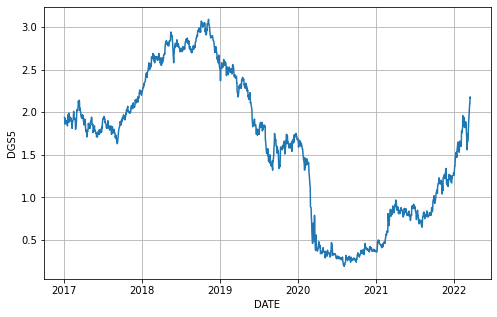

In [30]:
sns.lineplot(data=DGS5, x=DGS5.index, y=DGS5.DGS5)
plt.grid()
plt.show()

In [31]:
free = DGS5.mean().tolist()
free = np.multiply(free,1/100)
free

array([0.01603645])

In [32]:
# GDP to extrapolate macro
GDP = web.DataReader(
    name = 'GDP', 
    data_source = 'fred',
    start = '2017-01-01',
    end = '2022-01-01'
)
GDP.head().dropna()

,GDP
DATE,
2017-01-01,19153.912
2017-04-01,19322.920
2017-07-01,19558.693
2017-10-01,19882.965
2018-01-01,20143.716


In [33]:
GDP['Growth'] = GDP['GDP'].pct_change()
GDP['Growth']

DATE
2017-01-01         NaN
2017-04-01    0.008824
2017-07-01    0.012202
2017-10-01    0.016579
2018-01-01    0.013114
2018-04-01    0.017314
2018-07-01    0.008130
2018-10-01    0.007465
2019-01-01    0.009045
2019-04-01    0.013698
2019-07-01    0.010134
2019-10-01    0.008809
2020-01-01   -0.009822
2020-04-01   -0.093287
2020-07-01    0.085285
2020-10-01    0.016038
2021-01-01    0.026103
2021-04-01    0.031887
2021-07-01    0.020289
2021-10-01    0.034743
Name: Growth, dtype: float64

In [41]:
GDP['SPX']=GDP['GDP'] # dummy

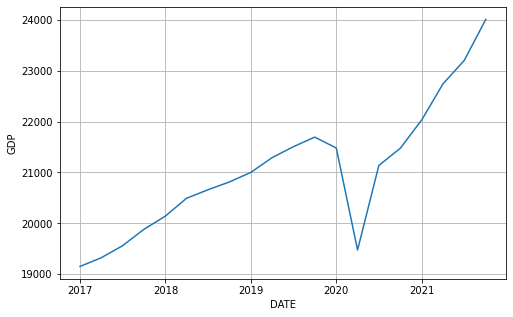

In [34]:
sns.lineplot(x=GDP.index,y=GDP.GDP)
plt.grid()
plt.show()

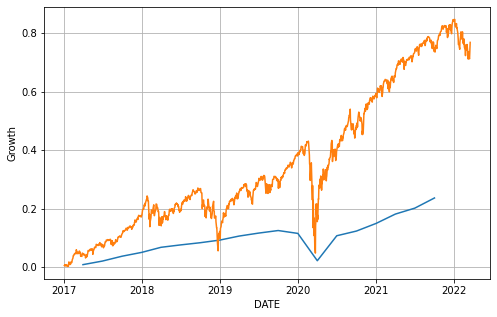

In [35]:
fig, ax = plt.subplots()
sns.lineplot(x=GDP.index,y=GDP.Growth.cumsum(),ax=ax)
sns.lineplot(x=daily_returns.index, y=daily_returns['^GSPC'].cumsum(),ax=ax)
plt.grid()
plt.show()



In [36]:
!pip install fuzzywuzzy 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process  # use process.extract()

# move macro aspects to another notebook
# Ratio of SPX to GDP (BI is market cap to GDP) 


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [37]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [42]:
for index, row in GDP.iterrows():
  nearestDate = nearest(close.index, index)
  print('Nearest date', index,':',nearestDate)
  GDP['SPX'][index] = close['^GSPC'][nearestDate]

GDP

Nearest date 2017-01-01 00:00:00 : 2017-01-03 00:00:00
Nearest date 2017-04-01 00:00:00 : 2017-03-31 00:00:00
Nearest date 2017-07-01 00:00:00 : 2017-06-30 00:00:00
Nearest date 2017-10-01 00:00:00 : 2017-10-02 00:00:00
Nearest date 2018-01-01 00:00:00 : 2018-01-02 00:00:00
Nearest date 2018-04-01 00:00:00 : 2018-04-02 00:00:00
Nearest date 2018-07-01 00:00:00 : 2018-07-02 00:00:00
Nearest date 2018-10-01 00:00:00 : 2018-10-01 00:00:00
Nearest date 2019-01-01 00:00:00 : 2018-12-31 00:00:00
Nearest date 2019-04-01 00:00:00 : 2019-04-01 00:00:00
Nearest date 2019-07-01 00:00:00 : 2019-07-01 00:00:00
Nearest date 2019-10-01 00:00:00 : 2019-10-01 00:00:00
Nearest date 2020-01-01 00:00:00 : 2019-12-31 00:00:00
Nearest date 2020-04-01 00:00:00 : 2020-04-01 00:00:00
Nearest date 2020-07-01 00:00:00 : 2020-07-01 00:00:00
Nearest date 2020-10-01 00:00:00 : 2020-10-01 00:00:00
Nearest date 2021-01-01 00:00:00 : 2020-12-31 00:00:00
Nearest date 2021-04-01 00:00:00 : 2021-04-01 00:00:00
Nearest da

,GDP,Growth,SPX
DATE,,,
2017-01-01,19153.912,NaN,2257.830078
2017-04-01,19322.920,0.008824,2362.719971
2017-07-01,19558.693,0.012202,2423.409912
2017-10-01,19882.965,0.016579,2529.120117
2018-01-01,20143.716,0.013114,2695.810059
2018-04-01,20492.492,0.017314,2581.879883
2018-07-01,20659.102,0.008130,2726.709961
2018-10-01,20813.325,0.007465,2924.590088
2019-01-01,21001.591,0.009045,2506.850098


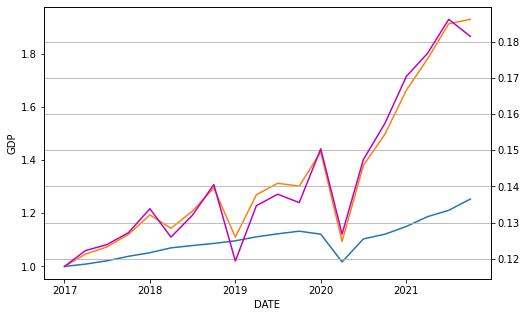

In [44]:
# variant of Buffet Indicator

fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.lineplot(x=GDP.index,y=GDP.GDP/GDP.GDP.min(),ax=ax)
sns.lineplot(x=GDP.index, y=GDP.SPX/GDP.SPX.min(),ax=ax)
sns.lineplot(x=GDP.index, y=GDP.SPX/GDP.GDP,ax=ax2,color='m')
plt.grid()
plt.show()

In [49]:
DGS5

,DGS5
DATE,
2017-01-02,NaN
2017-01-03,1.94
2017-01-04,1.94
2017-01-05,1.86
2017-01-06,1.92
...,...
2022-03-11,1.96
2022-03-14,2.10
2022-03-15,2.10


In [50]:
dfCAPM = pd.DataFrame(pAvg,columns=['Mean'])
dfCAPM

,Mean
^GSPC,0.147750
GOOG,0.274579
BRK-B,0.166269
NVDA,0.555450
AAPL,0.387641
MSFT,0.351659
TSM,0.329605
XLK,0.261370
F,0.160432
XLY,0.182952


In [51]:
dfCAPM['Cumsum'] = daily_returns.cumsum().iloc[-1]
dfCAPM['Variance'] = pCov_np.diagonal().tolist()
dfCAPM['Beta'] = pCov_np[0,:]/pCov_np[0,0]
marketReturn = dfCAPM.Mean['^GSPC']
dfCAPM['EV'] = free + dfCAPM.Beta*(marketReturn - free)
dfCAPM['SharpeExPost'] = dfCAPM['Mean']/np.sqrt(dfCAPM['Variance'])
dfCAPM['SharpeExAnte'] = dfCAPM['EV']/np.sqrt(dfCAPM['Variance'])
dfCAPM['EV_Adj'] = dfCAPM['EV']*(0.618) + dfCAPM['Mean']*(1-0.618)  # Golden proportion
dfCAPM['EV_H'] = 2*(dfCAPM['EV'] * dfCAPM['Mean'])/(dfCAPM['EV']+dfCAPM['Mean'])  # Harmonic mean for growth rate
# Harmonic mean turns out to be quite close to the golden ratio
dfCAPM['Row']=dfCAPM.reset_index().index
dfCAPM

,Mean,Cumsum,Variance,Beta,EV,SharpeExPost,SharpeExAnte,EV_Adj,EV_H,Row
^GSPC,0.147750,0.768065,0.002362,1.000000,0.147750,3.039918,3.039918,0.147750,0.147750,0
GOOG,0.274579,1.427373,0.004749,1.092974,0.159996,3.984439,2.321715,0.203766,0.202181,1
BRK-B,0.166269,0.864335,0.002894,0.895047,0.133926,3.090600,2.489412,0.146281,0.148355,2
NVDA,0.555450,2.887460,0.014447,1.640523,0.232115,4.621255,1.931161,0.355629,0.327410,3
AAPL,0.387641,2.015120,0.005857,1.207172,0.175037,5.064999,2.287071,0.256252,0.241174,4
MSFT,0.351659,1.828067,0.004870,1.199852,0.174073,5.039394,2.494529,0.241911,0.232873,5
TSM,0.329605,1.713421,0.006340,1.020726,0.150480,4.139560,1.889901,0.218906,0.206625,6
XLK,0.261370,1.358707,0.003848,1.193614,0.173251,4.213186,2.792752,0.206913,0.208378,7
F,0.160432,0.833994,0.009035,1.095720,0.160357,1.687834,1.687046,0.160386,0.160395,8
XLY,0.182952,0.951062,0.002826,1.002061,0.148021,3.441815,2.784669,0.161365,0.163644,9


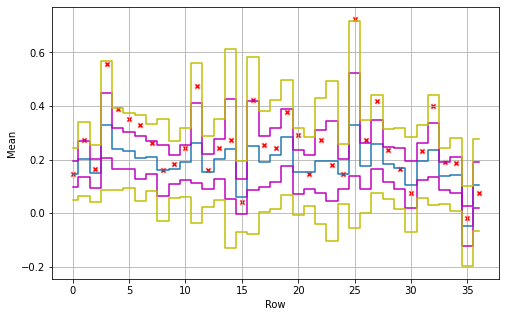

In [52]:
fig, ax = plt.subplots()
exAnte = 'EV_H'  # choose EV_H or EV_Adj or EV
exPost = 'Mean'
sns.scatterplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM[exPost],ax=ax,color='r',marker="X")
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM[exAnte],ax=ax,drawstyle='steps-mid')
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM[exAnte] + np.sqrt(dfCAPM.Variance),ax=ax,color='m',drawstyle='steps-mid')
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM[exAnte] - np.sqrt(dfCAPM.Variance),ax=ax,color='m',drawstyle='steps-mid')
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM[exAnte] + 2*np.sqrt(dfCAPM.Variance),ax=ax,color='y',drawstyle='steps-mid')
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM[exAnte] - 2*np.sqrt(dfCAPM.Variance),ax=ax,color='y',drawstyle='steps-mid')
plt.grid()
plt.show()


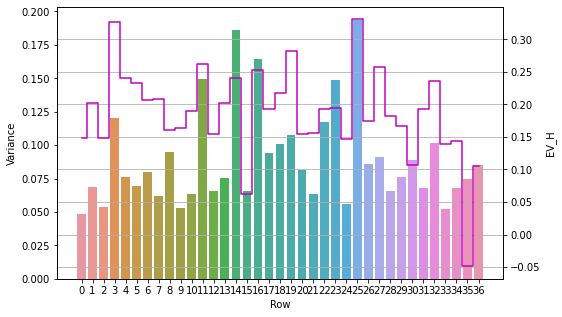

In [53]:
fig, ax = plt.subplots()
sns.barplot(data=dfCAPM,x=dfCAPM.Row,y=np.sqrt(dfCAPM.Variance),ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM.EV_H,ax=ax2,color='m',drawstyle='steps-mid')
plt.grid()
plt.show()

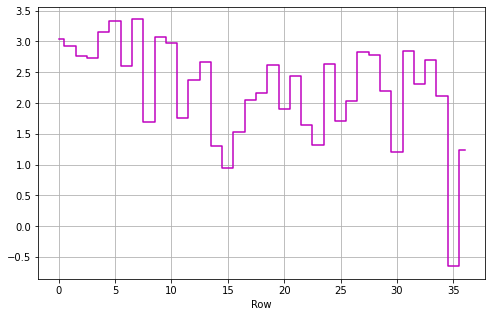

In [54]:
sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM.EV_H/np.sqrt(dfCAPM.Variance),color='m',drawstyle='steps-mid')
#sns.lineplot(data=dfCAPM,x=dfCAPM.Row,y=dfCAPM.EV_H/(2*np.sqrt(dfCAPM.Variance)),color='r',drawstyle='steps-mid')
plt.grid()
plt.show()

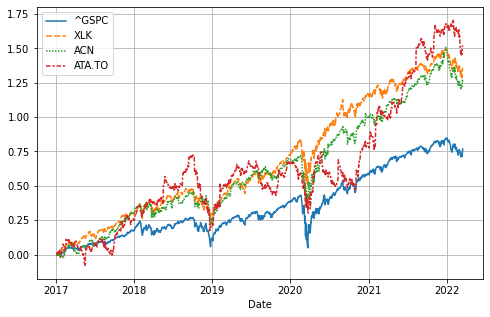

In [55]:
sns.lineplot(data=daily_returns[['^GSPC','XLK','ACN','ATA.TO']].cumsum())
plt.grid()
plt.show()

**Markowitz optimal portfolio**

In [56]:
dfCAPM.Mean.to_numpy()

array([ 0.14774983,  0.27457863,  0.16626905,  0.55545037,  0.38764139,
        0.35165869,  0.32960469,  0.2613696 ,  0.16043237,  0.18295239,
        0.24197776,  0.47279538,  0.16160893,  0.24233986,  0.27373798,
        0.04007175,  0.4236286 ,  0.25268837,  0.24334017,  0.37898731,
        0.29284503,  0.14804179,  0.27193962,  0.18125408,  0.14737043,
        0.723062  ,  0.27371056,  0.41778643,  0.2346573 ,  0.16427355,
        0.07578163,  0.2331143 ,  0.39848809,  0.19246931,  0.18687665,
       -0.01934716,  0.07641908])

In [57]:
k = dfCAPM.shape  # k is a tuple
k[0]

37

In [58]:
# Groups
gNYSE = ['^GSPC']
gAnchors = ['GOOG','BRK-B', 'NVDA', 'AAPL', 'MSFT', 'TSM']
gAI = ['XLK', 'F', 'ACN', 'ITW', 'TXN', 'IBM', 'CGNX', 'AMAT','ATA.TO']
gAImed = ['XLY', 'EXAS','EDIT','CRSP','ILMN']
gEmerging = ['XLF']
gEnergy = ['FSLR', 'OXY', 'XLB', 'LAC', 'LNG']
gStrategic = ['ASML', 'HD', 'JPM', 'WFC', 'V', 'TRTN', 'WM']
gREITs = ['EQIX']
gAgri = ['BAYN.DE', 'DD']

group = [gNYSE, gAnchors, gAI, gAImed, gEmerging, gEnergy, gStrategic, gREITs,gAgri]
# gAI + gAImed

In [59]:
len(group)

9

In [60]:
aMat = np.zeros((len(group),k[0]))  #  groups

In [61]:
group.index(gAnchors)

1

In [62]:
# 
for index, row in dfCAPM.iterrows():
  print(index ,':', row['Mean'])
  for gRow in group:
    i = group.index(gRow)
    for sym in gRow:
      if sym == index:
        j = int(row['Row'])
        aMat[i][j] = 1

^GSPC : 0.14774983429818
GOOG : 0.2745786254311925
BRK-B : 0.16626904951695698
NVDA : 0.5554503692015242
AAPL : 0.3876413897318872
MSFT : 0.35165868693588764
TSM : 0.3296046931995078
XLK : 0.2613695979920498
F : 0.16043236634834274
XLY : 0.18295238615573722
ACN : 0.24197775575075806
EXAS : 0.4727953783398227
ITW : 0.1616089263790673
TXN : 0.24233986220373957
EDIT : 0.2737379754807996
IBM : 0.04007175018741665
CRSP : 0.42362859841448147
ILMN : 0.2526883658324727
CGNX : 0.24334016694712315
AMAT : 0.37898731189511814
ATA.TO : 0.2928450261286146
XLF : 0.1480417912327347
FSLR : 0.27193961957014584
OXY : 0.18125407686025144
XLB : 0.14737042944263354
LAC : 0.7230620002791456
LNG : 0.2737105565154383
ASML : 0.4177864306729694
HD : 0.2346573041492252
JPM : 0.16427355262282678
WFC : 0.07578162861634455
V : 0.23311430310024508
TRTN : 0.3984880892886034
WM : 0.19246930992782474
EQIX : 0.18687664828796283
BAYN.DE : -0.019347159921044115
DD : 0.07641908194917055


In [63]:
aMat

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,

In [64]:
aMat.shape

(9, 37)

In [65]:
# rhs of the allocation vector
b = np.zeros(len(group))
b = np.multiply([10.,39.,22.,3.,5.,4.,5.,1.,1.],1/100)
fund = b.sum()  # excluding bonds and cash
b.shape

(9,)

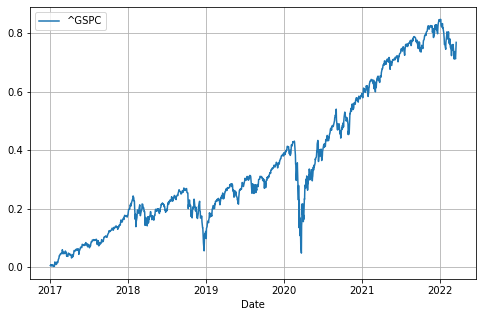

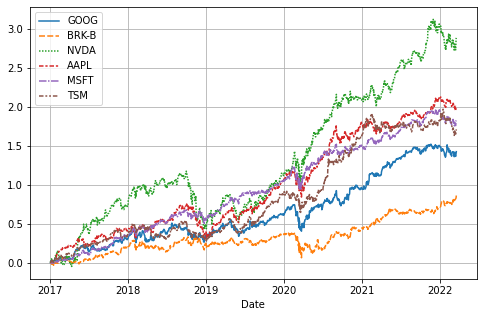

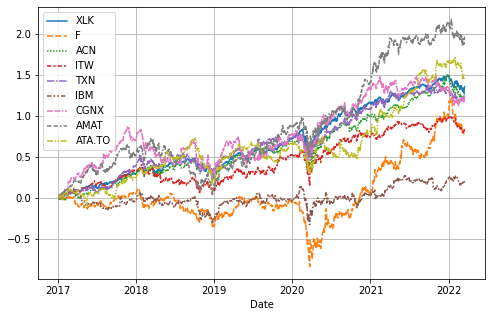

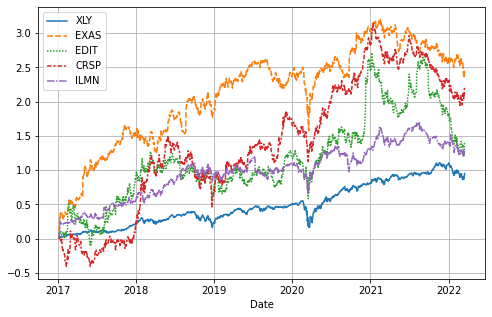

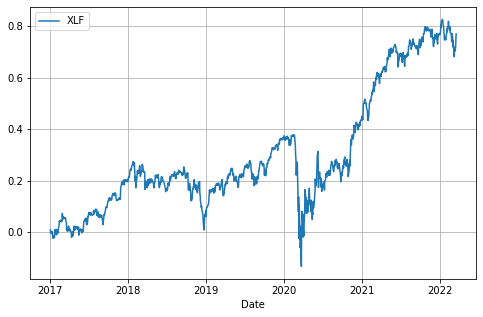

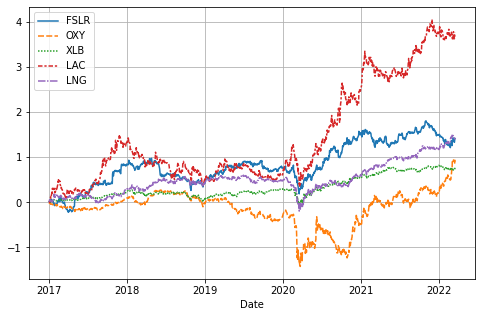

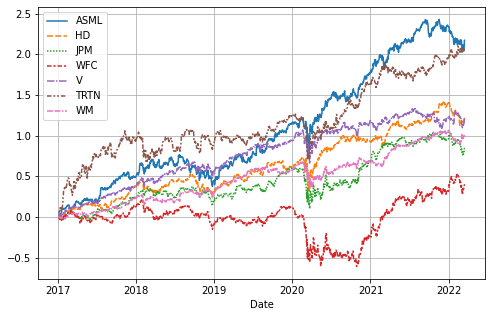

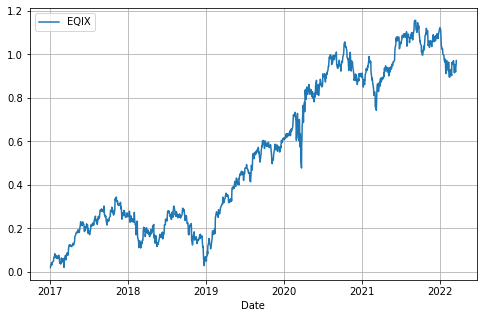

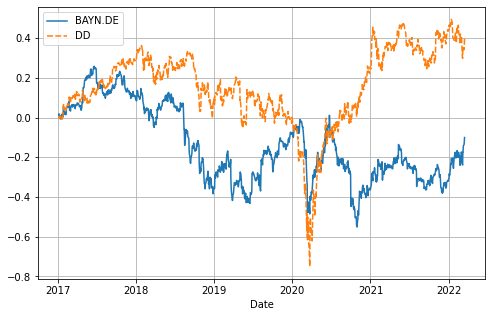

In [66]:
for ig in group:
  sns.lineplot(data=daily_returns[ig].cumsum())
  plt.grid()
  plt.show()

In [67]:
# Portfolio return
def pReturn(alloc):
    #return np.dot(pAvg.to_numpy(),alloc)
    return np.dot(dfCAPM['EV_H'].to_numpy(),alloc)

In [68]:
# Portfolio variance
def pVar(alloc):
    return np.dot(np.matmul(pCov.to_numpy(),alloc),alloc)

In [69]:
# Sharpe ratio
# negative sign for minimization
def sharpeRatio(alloc):
  return -pReturn(alloc)/np.sqrt(pVar(alloc))
  #return -pReturn(alloc)

In [70]:
# We use an anonymous lambda function
# alloc > 0 as Long position only
#fund = 0.9238  # exclude cash and Gogoro reserve
#cons = ({'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - fund})
cons = ({'type': 'eq', 'fun': lambda x: np.matmul(aMat,x) - b})

In [71]:
# Repeat the list with the value (1/n) n times, and convert list to array
equalAlloc = np.array(
  [1 / len(symbols)] * len(symbols)
)

In [72]:
equalAlloc.shape

(37,)

In [73]:
# This creates n tuples of (0, 1), all of which exist within a container tuple
# We essentially create a sequence of (min, max) pairs
bnds = tuple(
  (0.001, 1) for s in symbols
)
bnds

((0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1),
 (0.001, 1))

In [74]:
# 
res = optimize.minimize(
  # Objective function
  fun = sharpeRatio,
  # fun = pReturn, 
  # Initial guess
  x0 = equalAlloc, 
  method = 'SLSQP',
  bounds = bnds, 
  constraints = cons
)
res

     fun: -3.680067023085548
     jac: array([ 0.46434179, -0.05894443, -0.11825424, -0.12883911, -0.12920374,
       -0.12875772, -0.12962371,  0.23021799,  0.29814166,  0.19703746,
        0.0043191 ,  0.01890102,  0.14893091,  0.26777065,  1.10937378,
        1.70536569,  0.01972693,  0.07820347,  0.67615804,  0.18842667,
        0.00323239,  0.4802185 ,  0.01010928,  0.79036286,  0.34928444,
       -0.55108836, -0.55204502, -0.23350501, -0.29993635,  0.37292138,
        1.70872718,  0.05148795, -0.56860772, -0.56837791, -0.23101184,
        2.89538375,  1.80318633])
 message: 'Optimization terminated successfully.'
    nfev: 436
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.1       , 0.001     , 0.001     , 0.02008977, 0.13905982,
       0.17635869, 0.05249172, 0.001     , 0.001     , 0.001     ,
       0.11800182, 0.02223484, 0.001     , 0.001     , 0.001     ,
       0.001     , 0.00476516, 0.001     , 0.001     , 0.001     ,
       0.09499818, 0.05     

In [75]:
# Expected return
returnSharpe = pReturn(res["x"])
round(returnSharpe, 4)

0.1816

In [76]:
opt = res["x"].tolist()
opt

[0.1,
 0.0010000000000003795,
 0.001,
 0.02008977254174904,
 0.13905981529527522,
 0.1763586911018554,
 0.052491721061120454,
 0.00100000000000036,
 0.001,
 0.001000000000000298,
 0.11800182258816327,
 0.022234844342032888,
 0.001,
 0.001,
 0.0010000000000004736,
 0.0010000000000004207,
 0.004765155657966741,
 0.001,
 0.0010000000000007171,
 0.001,
 0.09499817741183675,
 0.05,
 0.0010000000000000872,
 0.0010000000000019965,
 0.0010000000000000614,
 0.01355276182376654,
 0.02344723817623131,
 0.001,
 0.001,
 0.0010000000000008487,
 0.0010000000000037362,
 0.001,
 0.0222307394334811,
 0.022769260566516614,
 0.01,
 0.0010000000000002073,
 0.008999999999999791]

In [77]:
# Standard deviation
sharpeSD = np.sqrt(pVar(res["x"]))
round(sharpeSD, 4)

0.0494

In [78]:
dfOptimal = pd.DataFrame(opt,index=symbols,columns=['MaxSharpe'])
dfOptimal

,MaxSharpe
^GSPC,0.100000
GOOG,0.001000
BRK-B,0.001000
NVDA,0.020090
AAPL,0.139060
MSFT,0.176359
TSM,0.052492
XLK,0.001000
F,0.001000
XLY,0.001000


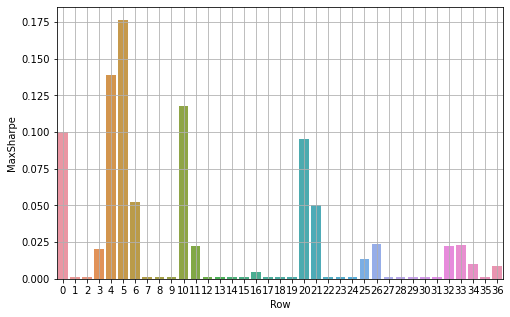

In [79]:
fig, ax = plt.subplots()
sns.barplot(data=dfOptimal,x=dfCAPM.Row,y=dfOptimal.MaxSharpe,ax=ax)
plt.grid()
plt.show()